<a href="https://colab.research.google.com/github/JuliaSidorova/IGRA/blob/master/IGRA_MAIN_ITOG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href='https://hostingkartinok.com/show-image.php?id=087321623a29001d957dd216a8008705' title='хостинг изображений'><img style="width:100%" src='https://s8.hostingkartinok.com/uploads/images/2019/05/087321623a29001d957dd216a8008705.jpg' alt='dataset-cover.jpg'  /></a>

# Команда 09TeamPy

Участники:
1.   Черных Сергей Викторович
2.   Волков Дмитрий Александрович
3.   Деев Вадим Александрович
4.   Сидорова Юлия Викторовна
5.   Сайфутдинов Фарин Ринатович
6.   Вершинин Алексей Николаевич
7.   Чернышев Иван Владиславович
8.   Ветошкин Дмитрий Александрович
9.   Тодорук Дмитрий Павлович
10.   Шуравин Евгений Петрович
11.   Мусорин Сергей Викторович

# Библиотеки

In [0]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg' 
import seaborn as sns
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
import os
import datetime
from sklearn.preprocessing import LabelEncoder

# Загрузка файлов с https://drive.google.com

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Загрузка данных в dataframe

In [0]:
info=pd.read_csv('/content/gdrive/My Drive/IGRA/informations_households.csv')
wdd=pd.read_csv('/content/gdrive/My Drive/IGRA/weather_daily_darksky.csv',parse_dates=[1,5,9,14,18,19,23,24,25,27,29,30])
whd=pd.read_csv('/content/gdrive/My Drive/IGRA/weather_hourly_darksky.csv')
acorn=pd.read_csv('/content/gdrive/My Drive/IGRA/acorn_details.csv',encoding = "ISO-8859-1")
holiday=pd.read_csv('/content/gdrive/My Drive/IGRA/uk_bank_holidays.csv')


**daily_dataset**

In [0]:
str_path='/content/gdrive/My Drive/IGRA/daily_dataset/'
files = os.listdir(str_path)
dd = pd.DataFrame()
for filename in files:
    temp = pd.read_csv( os.path.join(str_path, filename),parse_dates=[1] )
    dd = pd.concat([dd, temp])   

Обычно, большие данные бывают "зашумлены" разного рода искажениями и случайными отклонениями, поэтому до начала анализа постараемся выяснить, какие данные стоит отфильтровать и не учитывать при анализе. Построим график зависимости количества работающих датчиков (которые передали не менее 48 показаний в  сутки) за каждый день исследования

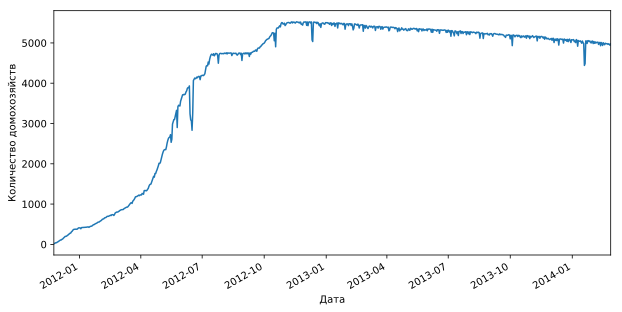

In [0]:
dd2 = dd.loc[dd['energy_count']==48]
dd2['day'].value_counts().plot()
plt.xlabel("Дата")
plt.ylabel("Количество домохозяйств")
plt.show()

На графике видно, что с конца 2011 года наблюдается резкое увеличение числа доступных датчиков, пик которого достигнут в 2013 году. т.е.конец 2011 года и  полностью 2012 год - это видимо период, когда датчики устанавливались. Далее видно плавное снижение количество доступных датчиков - период нормальной эксплуатации - некоторые датчики выходят из строя. Поскольку в дальнейшем мы будем анализировать потребление в зависимости от разных факторов, в том числе от сезона, то для анализа нужно взять период кратный году. Наиболее подходящий - это 2013 год, когда количество работающих датчиков менялось незначительно.

In [0]:
start_date=datetime.datetime(year=2013,month=1,day=1)
end_date=datetime.datetime(year=2013,month=12,day=31)

In [0]:
dd2=dd2[(dd2['day']>=start_date)&(dd2['day']<=end_date)]

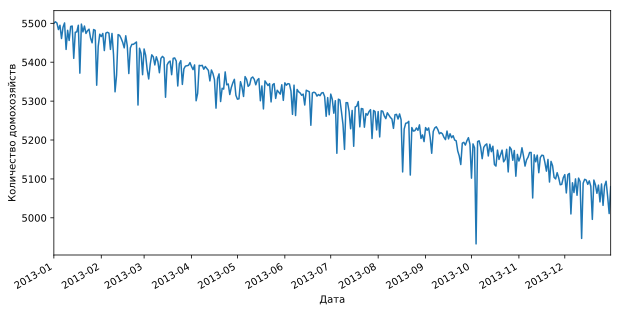

In [0]:
dd2['day'].value_counts().plot()
plt.xlabel("Дата")
plt.ylabel("Количество домохозяйств")
plt.show()

Новый график выглядит более гладким, тем не  менее, из него понятно, что за 2013 год вышло из строя около 400 датчиков. Желательно их исключить, так как они могут исказить картину, поскольку работали не весь год, а это может исказить распределение потребления по сезонам. К тому же, вышедший из строя датчик - потенциально не надежен - с бОльшой вероятностью он мог передавать неверные показания. Оставим для анализа только датчики, которые проработали не менее 350 дней в году:

In [0]:
dd_stat=dd2[['LCLid','day']]
dd_stat=dd_stat.groupby(['LCLid']).count()
d = dd_stat[(dd_stat['day']<=350)].reset_index()
list_LCLid = d['LCLid'].unique()
dd2=dd2[~dd2['LCLid'].isin(list_LCLid)]

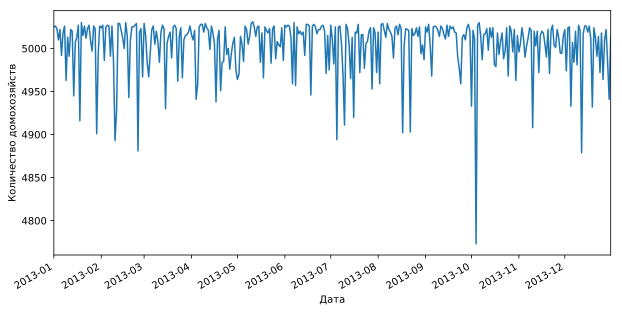

In [0]:
dd2['day'].value_counts().plot()
plt.xlabel("Дата")
plt.ylabel("Количество домохозяйств")
plt.show()

Может показатся, что отброшено слишком много данных, но тем не менее, для анализа мы используем более половины всего датасета:

In [0]:
len(dd2)/len(dd)*100

52.03338163696615

Сгруппируем датчики по максимальному и среднему потреблению. Потом отсортируем по соотношению максимальное/среднее потребление (слишком большее соотношение будет подозрительно):

In [0]:
dd3 = dd2.groupby('LCLid').agg(['max', 'mean'])['energy_sum'].reset_index()
dd3['over'] = dd3['max']/dd3['mean']
dd3.sort_values(by = 'over', ascending=False).head(10)

LCLid      max      mean        over
167   MAC000197    8.259  0.025699  321.375685
2305  MAC002594    0.854  0.003492  244.575924
1894  MAC002136    0.042  0.000188  222.970588
4223  MAC004672    0.302  0.001989  151.836565
2277  MAC002564    1.945  0.060756   32.013212
1152  MAC001309    1.487  0.050438   29.481532
1206  MAC001372   22.988  1.234202   18.625797
1748  MAC001976    8.341  0.471846   17.677372
3883  MAC004298   51.756  3.040348   17.023052
3988  MAC004410  120.603  7.100767   16.984503

Обнаружили несколько датчиков с аномально высоким соотношением. Построим графики потребления по дням для некоторых их них:

<Figure size 720x360 with 0 Axes>

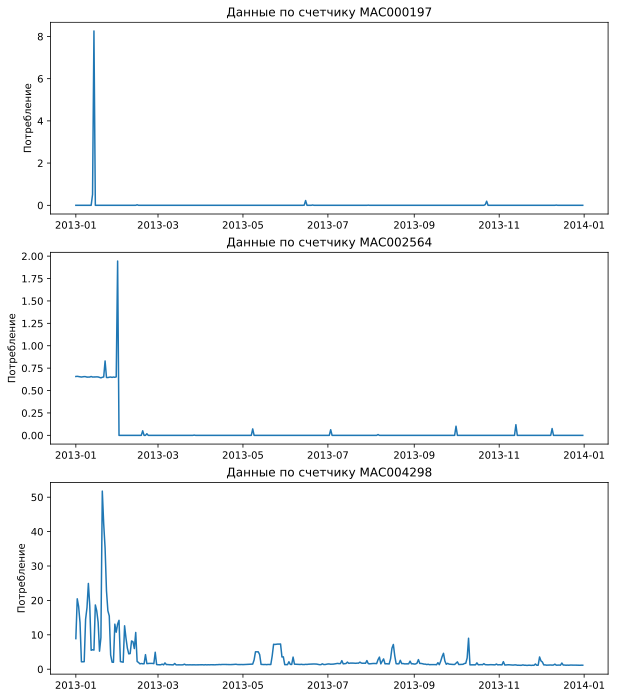

In [0]:
fig = plt.figure()
fig, axes = plt.subplots(3, 1, figsize=(10,12))
dd_stat0 = dd2.loc[dd2['LCLid']=='MAC000197'].groupby(['day']).agg(['sum'])['energy_sum']
dd_stat1 = dd2.loc[dd2['LCLid']=='MAC002564'].groupby(['day']).agg(['sum'])['energy_sum']
dd_stat2 = dd2.loc[dd2['LCLid']=='MAC004298'].groupby(['day']).agg(['sum'])['energy_sum']

axes[0].plot(dd_stat0)
axes[0].set_title('Данные по счетчику MAC000197')
axes[0].set_ylabel("Потребление")
axes[1].plot(dd_stat1)
axes[1].set_title('Данные по счетчику MAC002564')
axes[1].set_ylabel("Потребление")
axes[2].plot(dd_stat2)
axes[2].set_title('Данные по счетчику MAC004298')
axes[2].set_ylabel("Потребление")
plt.show()

Видно, что MAC000197 передал ненулевые значения  только 4 дня. MAC002564 передавал данные в течении января, а после тоже только почти нулевые. Последний MAC004298 с соотношением  17, показывает более равномерный график в течении года, но тоже похоже, что нормальная рабта этого датчика была только первые два месяца. 

Отсортируем датафрейм по среденедневному потреблению. Учитывая, что потребление только холодильника около 0,5 кВ/час в день - более низкие значения скорее всего некорректны:

In [0]:
dd3.sort_values(by = 'mean').head(15)

LCLid     max      mean        over
3258  MAC003627   0.000  0.000000         NaN
3673  MAC004067   0.000  0.000000         NaN
1894  MAC002136   0.042  0.000188  222.970588
4223  MAC004672   0.302  0.001989  151.836565
2305  MAC002594   0.854  0.003492  244.575924
167   MAC000197   8.259  0.025699  321.375685
1152  MAC001309   1.487  0.050438   29.481532
2277  MAC002564   1.945  0.060756   32.013212
32    MAC000037   0.862  0.081527   10.573123
2119  MAC002388   0.491  0.332074    1.478586
4581  MAC005069   4.195  0.458177    9.155854
1748  MAC001976   8.341  0.471846   17.677372
357   MAC000408   1.484  0.541570    2.740180
4800  MAC005313   5.160  0.676602    7.626342
2559  MAC002873  11.849  0.785458   15.085460

Так и есть. Это все те же самые датчики с высоким соотношением максимума к среднему. Исключим эти датчики из анализа как неисправные:

In [0]:
list_LCLid_2 = ['MAC003627', 'MAC004067', 'MAC002136', 'MAC004672' ,'MAC002594', 'MAC000197' ,'MAC001309' , 'MAC002564', 'MAC000037', 'MAC002388','MAC005069', 'MAC001976' ,'MAC001372' ]
dd2=dd2[~dd2['LCLid'].isin(list_LCLid_2)]  

**hhblock_dataset**

In [0]:
str_path='/content/gdrive/My Drive/IGRA/hhblock_dataset/'
files = os.listdir(str_path)
hhb_data = pd.DataFrame()
for filename in files:
    temp = pd.read_csv( os.path.join(str_path, filename),parse_dates=[1])
    temp=temp[(temp['day']>=start_date)&(temp['day']<=end_date)]
    hhb_data = pd.concat([hhb_data, temp])   

**halfhourly_dataset**

In [0]:
str_path='/content/gdrive/My Drive/IGRA/halfhourly_dataset/'
files = os.listdir(str_path)
hh_data = pd.DataFrame()
for filename in files:
    temp = pd.read_csv( os.path.join(str_path, filename),parse_dates=[1])
    temp=temp[(temp['tstp']>=start_date)&(temp['tstp']<=end_date)]
    hh_data = pd.concat([hh_data, temp])   

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Добавим 3 колонки - день недели, месяц и время года

In [0]:
res = dd2.merge(info, on='LCLid', how='left')[['LCLid',	'day','energy_sum','stdorToU'	,'Acorn']]
res['dn']=res['day'].dt.weekday
res['mon']=res['day'].dt.month
def seasons(row):
  if 3<=row['mon'] <=5:
    return '2 - Весна'
  if 6<=row['mon'] <=8:
    return '3 - Лето'
  if 9<=row['mon'] <=11:
    return '4 - Осень'
  return '1 - Зима'
res['season'] = res.apply(seasons, axis=1)

Посчитаем среднее значение потребления электричества по всему датасету

In [0]:
energy_mean = res['energy_sum'].mean()
print(energy_mean)
res['diff'] = 100*(res['energy_sum'] - energy_mean)/energy_mean

10.106581462651457


Рассмотрим распределение среднего потребления электричества по дням недели:

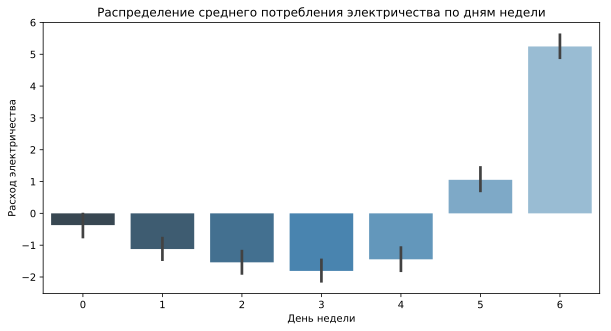

In [0]:
graf=sns.barplot(x = 'dn', y = 'diff', data = res, palette="Blues_d")
graf.set(xlabel='День недели', ylabel='Расход электричества',title='Распределение среднего потребления электричества по дням недели')
plt.show()

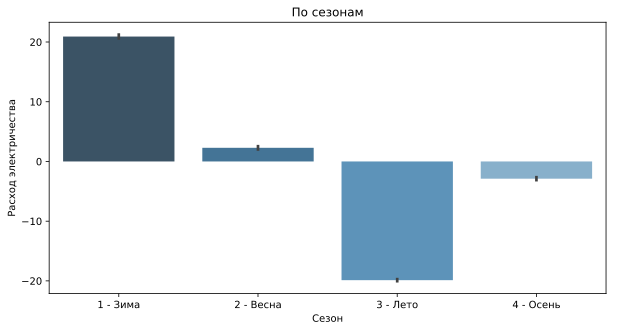

In [0]:
graf=sns.barplot(x = 'season', y = 'diff', data = res, palette="Blues_d")
graf.set(xlabel='Сезон', ylabel='Расход электричества',title='По сезонам')
plt.show()

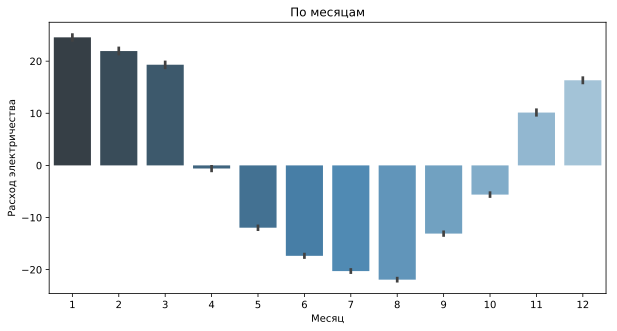

In [0]:
graf=sns.barplot(x = 'mon', y = 'diff', data = res, palette="Blues_d")
graf.set(xlabel='Месяц', ylabel='Расход электричества',title='По месяцам')
plt.show()

Пик потребления приходится на воскресенье, более +5% от среднего, в течении других дней недели потребелении более равномерное. Сильно зависит среденее потреблени от сезона, до -20% летом и +20% зимой. Максимальное потребление достигается в декабре, а минимум в августе. Таким образом сезон - более важный фактор с потреблении эл.энергии, разброс до 40%, в то время как от дня недели зависимоcть более слабая.

# Построим график потребления электричества в зависимости от типа счетчика и даты

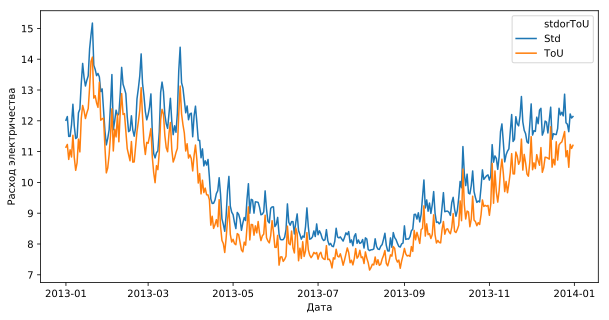

In [0]:
graf=sns.lineplot(x=res.day, y=res.energy_sum,hue=res.stdorToU, ci=None)
graf.set(xlabel='Дата', ylabel='Расход электричества')
plt.show()

По графику видно, что люди со стандартным тарифом  тратят электричество больше ,чем люди с динамическим тарифом

In [0]:
energy_std_mean = res[res['stdorToU'] == 'Std']['energy_sum'].mean()
energy_ToU_mean = res[res['stdorToU'] == 'ToU']['energy_sum'].mean()
print('Среднесуточное потребление при установленом стандартном счетчике: {:.3f} кВатт/чаc, при динамическим: {:.3f} кВатт/чаc'.format(energy_std_mean, energy_ToU_mean))
print('Потребление при стандартном счетчике больше на {:.2f} % чем при динамическим.'.format(100*(energy_std_mean-energy_ToU_mean)/energy_ToU_mean))

Среднесуточное потребление при установленом стандартном счетчике: 10.275 кВатт/чаc, при динамическим: 9.450 кВатт/чаc
Потребление при стандартном счетчике больше на 8.74 % чем при динамическим.


Проанализируем количество установленных датчиков по групппам потребителей Acorn:

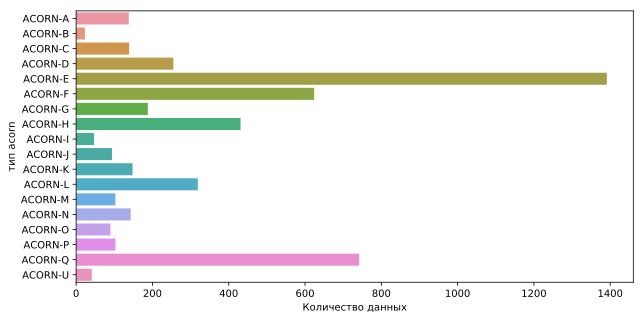

In [0]:
acorn_counts = res.groupby(['Acorn','LCLid']).count().reset_index()
acorn_counts = acorn_counts.groupby('Acorn').count().reset_index()
graf=sns.barplot(x=acorn_counts.dn,y=acorn_counts.Acorn)
graf.set(xlabel='Количество данных',ylabel='тип acorn')
plt.show()

Видим, что имеется значительная неравномерность в распределении датчиков по группам, так Acorn-E представлены около 1400 датчиков, а количество датчиков в группах Acorn-B,I,U не дотягиват и до сотни. Таким образом, наибольший вклад в результаты иследования вносят группы Acorn -E,F,Q ввиду многочисленности датчиков. Целесообразно в дальнейшем рассмотреть статистику потребления по "малочисленным" Acorn отдельно.

**Построим график потребления электричества в зависимости от типа счетчика и времени года**

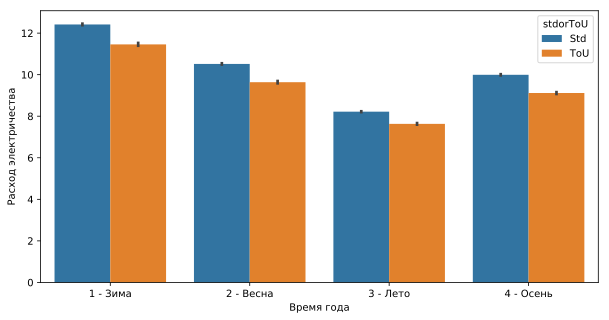

In [0]:
graf=sns.barplot(x=res.season, y=res.energy_sum,hue=res.stdorToU)
graf.set(xlabel='Время года', ylabel='Расход электричества')
plt.show()

По графику видно, что существует связь между потреблением электроэнергии и временем года. Сезонный эффект очень очевиден,  т.к. используют электричество в качестве источника тепла. В теплое время (лето) электроэнергии тратится меньше, чем в холодное время (зима, осень, весна)  

**График потребления электричества в зависимости от типа Acorn**

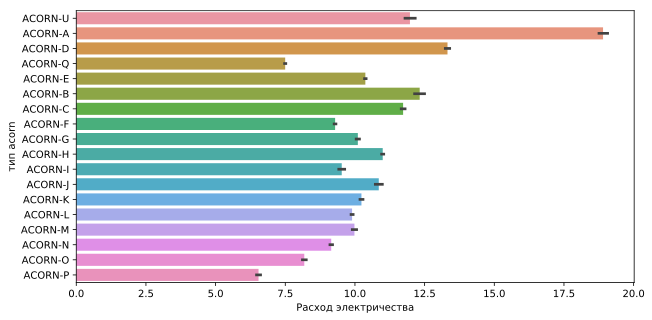

In [0]:
graf=sns.barplot(x=res.energy_sum,y=res.Acorn)
graf.set(xlabel='Расход электричества',ylabel='тип acorn')
plt.show()

В целом наблюдается тенденция снижения потребеления от группы Acorn-A к групппе Acorn-Q, т.е. от богатых к бедным. Люди из ACORN-A тратят примерно в три раза больше электроэнергии, чем люди из группы ACORN-P, т.е это разница в 300% и пока это наиболее значимый фактор.

**График потребления электричества в зависимости от дня недели**

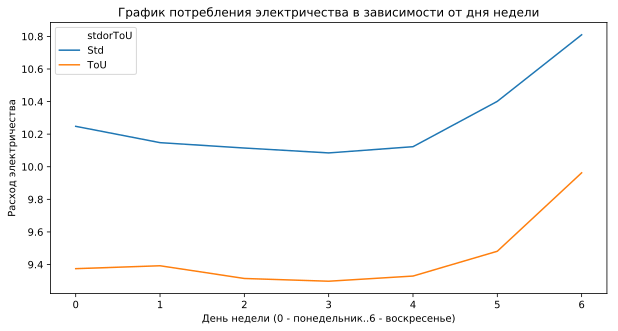

In [0]:
graf=sns.lineplot(x=res.dn,y=res.energy_sum,hue=res.stdorToU, ci=None)
graf.set(xlabel='День недели (0 - понедельник..6 - воскресенье)',ylabel='Расход электричества',title='График потребления электричества в зависимости от дня недели')
plt.show()

По графику видно, что в выходные дни потребление электричества увеличивается, по сравнению с рабочими днями

**Построим графики почасового потребления электроэнергии**

In [0]:
res2 = hhb_data.merge(info, on='LCLid', how='left')
res2['mon']=res2['day'].dt.month
res2['dn']=res2['day'].dt.weekday
res2=res2.drop(['LCLid'	,'day','Acorn_grouped',	'file'],axis=1)
res2=res2.groupby(['stdorToU',	'Acorn','dn',	'mon']).mean().reset_index()
list_colums=list(res2.columns.values)[4:]
res22=pd.melt(res2,id_vars=['stdorToU',	'Acorn','dn',	'mon'], value_vars=list_colums,var_name='dt',value_name='val')
def times(row):
  t=int(row['dt'][3:])
  if t%2!=0:
    return str(t//2)+':30'
  return str(t//2)+':00'  
res22['tt']= res22.apply(times, axis=1)

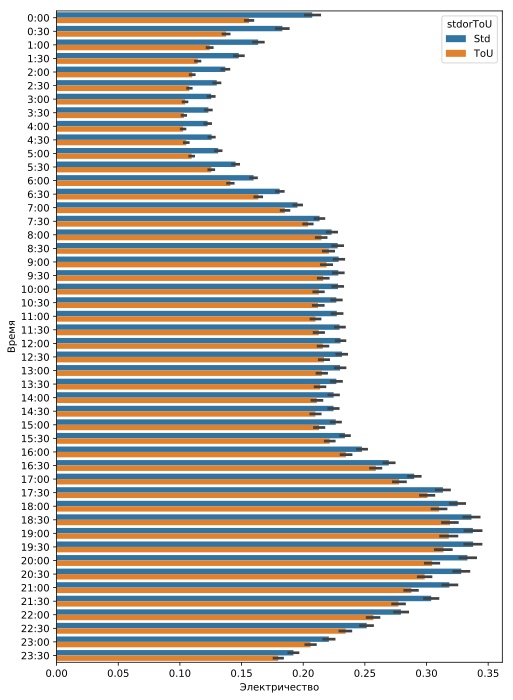

In [0]:
rcParams['figure.figsize'] = 8, 12
graf=sns.barplot(y=res22.tt,x=res22.val,hue=res22.stdorToU	)
graf.set(ylabel='Время', xlabel='Электричество')
plt.show()

Из графика видно, что пик потребления электричества приходится на вечернее время с 18:30 до 20:00 часов, наименьшее потребление электроэнергии с 02:00 до 04:00 часов. Разница в потреблении примерно трехкратная. Причем, это верно как для стандартного счетчика, так и для многотарифного. Многотарифная оплата за электроэнергию призвана в первую очередь стимулировать потребителей потреблять энергию в часы наименьшей нагрузки и снижать потребление в часы пик, т.е. выравнивать потребеление в течении суток. Как видно из графика -  ожидания многотарфиных счетчиков не оправдываются. Хотя в целом, люди, кто установил многотарифный счетчик электроэнергию используют более экономно. 

Поскольку есть сильная зависимоть потребления от сезона, то построим графики часового потребления отдельно для декабря и для августа:

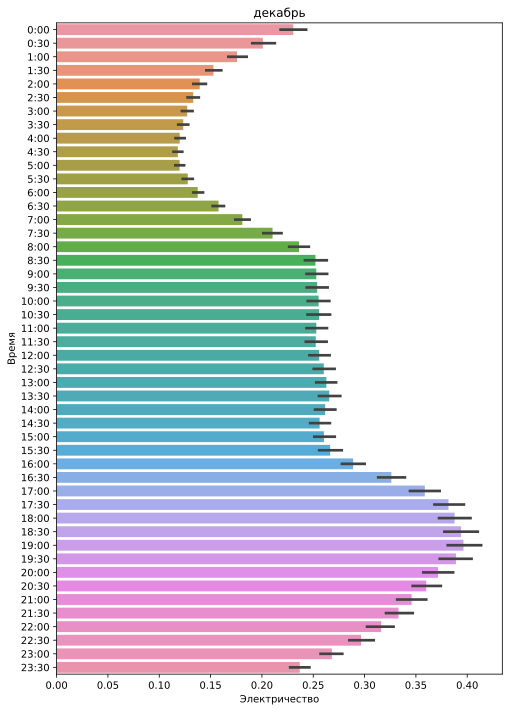

In [0]:
res22_12 = res22[res22['mon']==12]
rcParams['figure.figsize'] = 8, 12
graf=sns.barplot(y=res22_12.tt,x=res22_12.val)
graf.set(ylabel='Время', xlabel='Электричество' , title = 'декабрь')
plt.show()

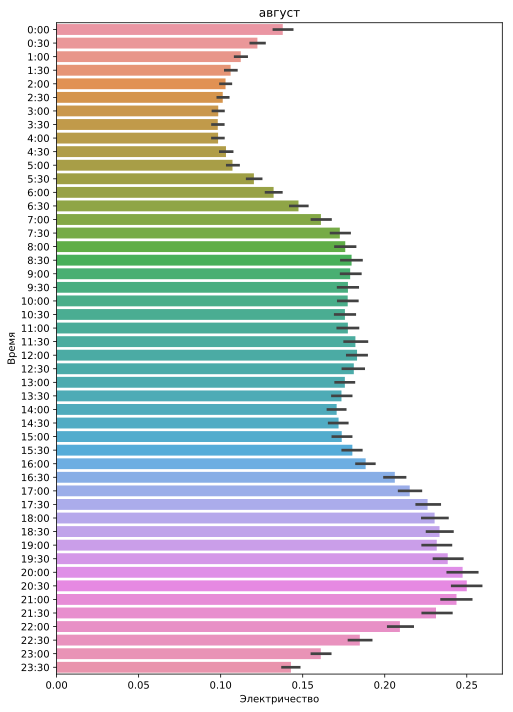

In [0]:
res22_08 = res22[res22['mon']==8]
rcParams['figure.figsize'] = 8, 12
graf=sns.barplot(y=res22_08.tt,x=res22_08.val)
graf.set(ylabel='Время', xlabel='Электричество', title = 'август')
plt.show()

Графики похожи, пики и минимумы приблизительно в одно и то же время, видимо это связано с рабочими часами, а не с солнечным ритмом. Минимум потребления и в декабре и в августе - ночью, около 0,1 кВтт/час, а вот днем заметна разница. По видимому сезонная разница больше связанна не с отоплением, а с коротким солнечным днем и недостатком света зимой, когда приходится чаще использовать искусственное освещение.

Посмотрим как распределяется потребление в рабочие и выходные дни:

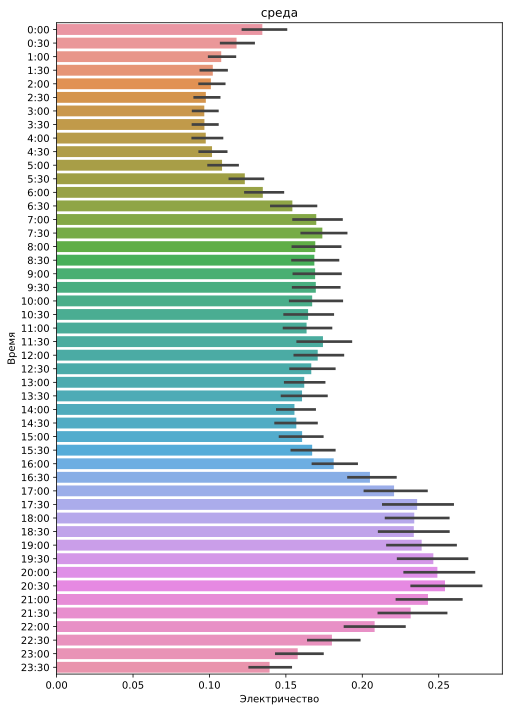

In [0]:
res22_wen = res22[res22['dn']==2]
rcParams['figure.figsize'] = 8, 12
graf=sns.barplot(y=res22_wen.tt,x=res22_08.val)
graf.set(ylabel='Время', xlabel='Электричество', title = 'среда')
plt.show()

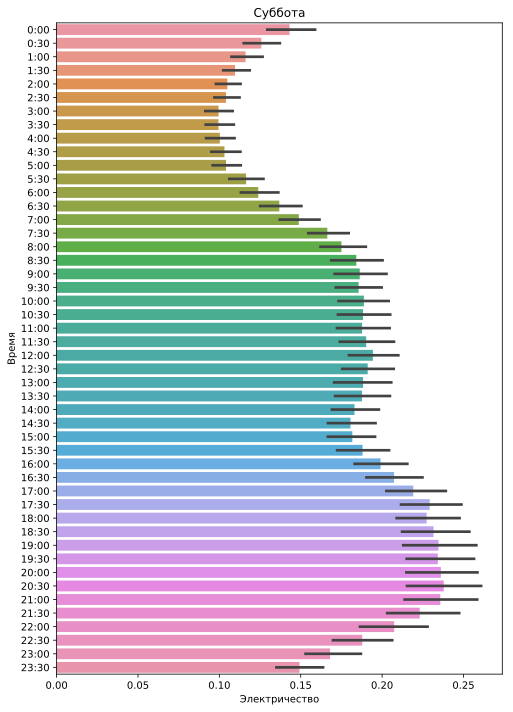

In [0]:
res22_sat = res22[res22['dn']==5]
rcParams['figure.figsize'] = 8, 12
graf=sns.barplot(y=res22_sat.tt,x=res22_08.val)
graf.set(ylabel='Время', xlabel='Электричество', title = 'Суббота')
plt.show()

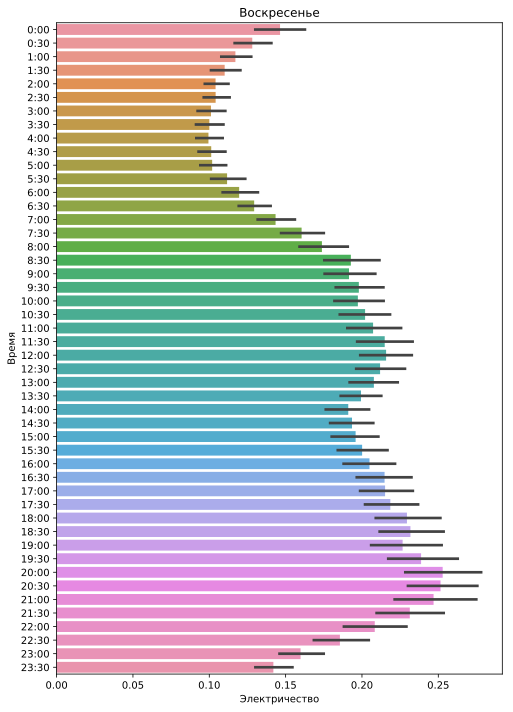

In [0]:
res22_sun = res22[res22['dn']==6]
rcParams['figure.figsize'] = 8, 12
graf=sns.barplot(y=res22_sun.tt,x=res22_08.val)
graf.set(ylabel='Время', xlabel='Электричество', title = 'Воскресенье')
plt.show()

В целом в выходные дни потребление днем более равномерно, чем в будни, особенно характерно воскресенье - потребление в течении дня с 8:00 до 20:00 равномерное, пик 20:00 не так выражен.

# Проанализируем отдельно  по каждому из Acorn.

In [0]:
list_acorn=sorted(res['Acorn'].unique())

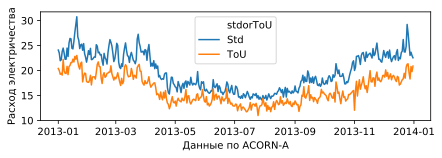

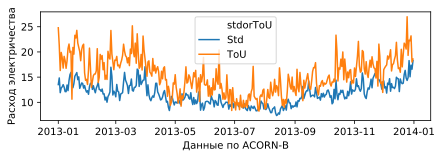

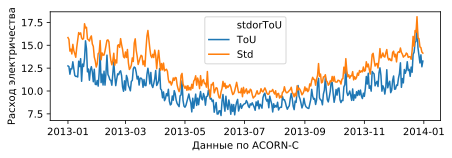

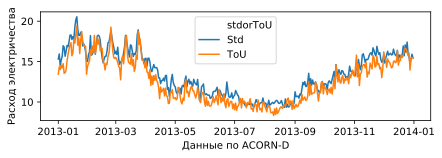

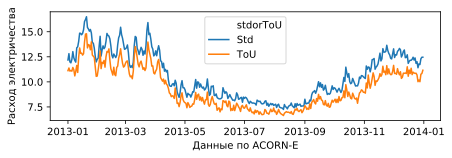

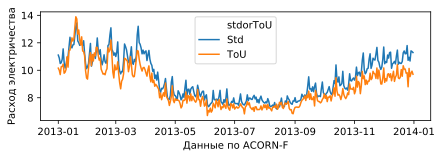

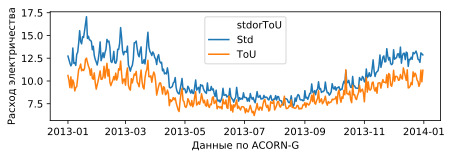

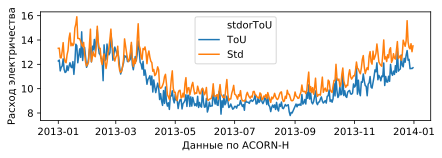

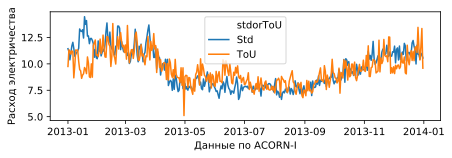

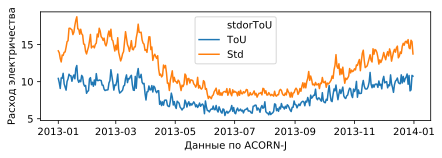

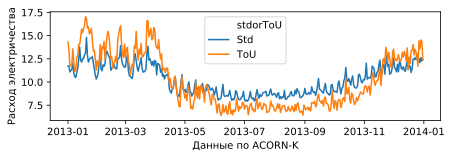

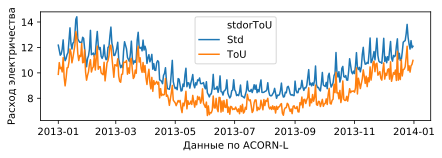

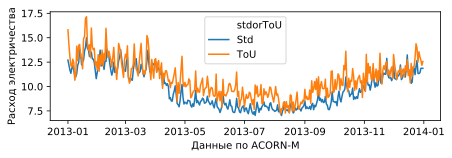

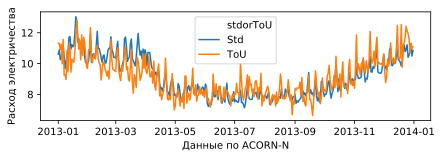

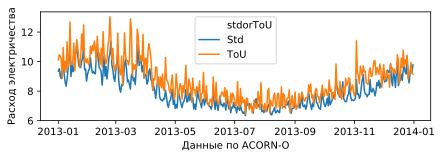

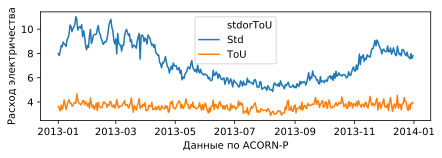

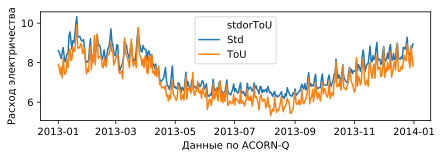

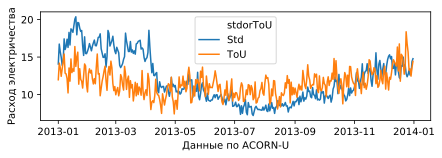

In [0]:
rcParams['figure.figsize'] = 7, 2
for i in list_acorn:
  tmp=res[res['Acorn']==i]
  graf=sns.lineplot(x=tmp.day, y=tmp.energy_sum,hue=tmp.stdorToU, ci=None)
  graf.set(xlabel='Данные по '+str(i),ylabel='Расход электричества')
  plt.show()

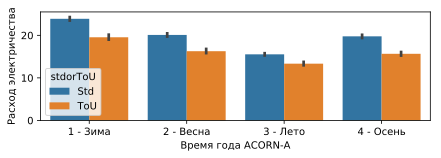

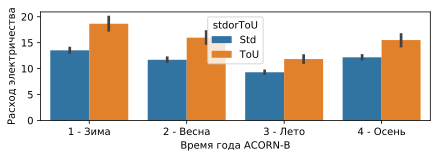

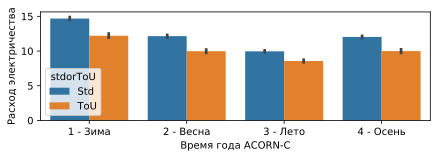

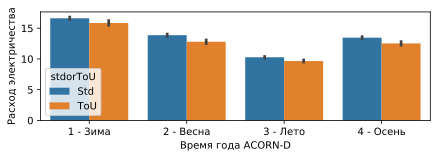

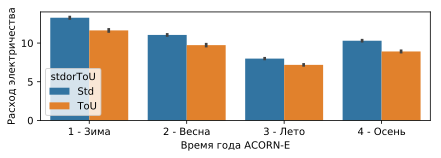

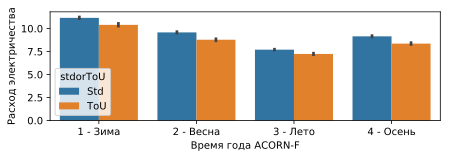

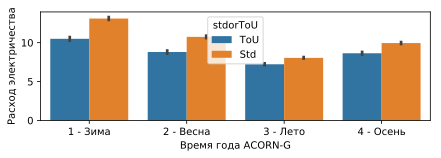

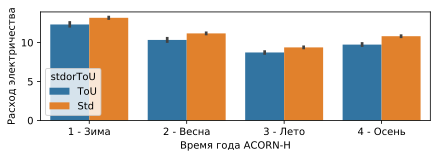

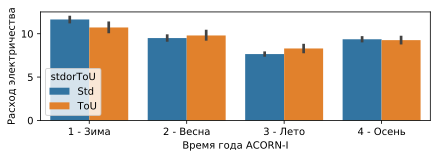

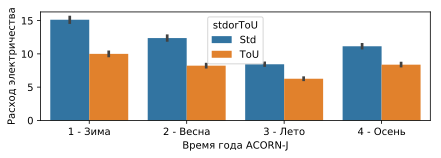

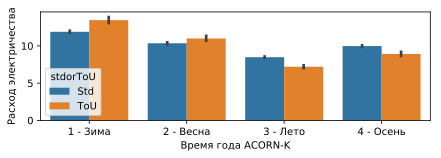

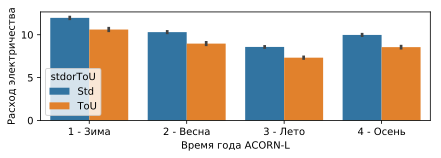

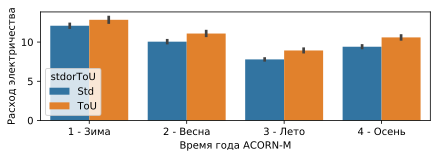

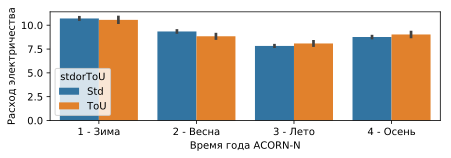

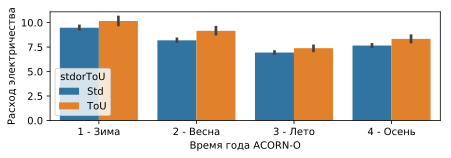

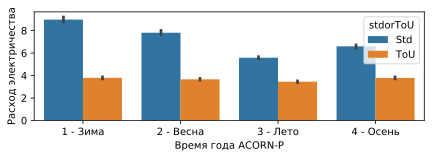

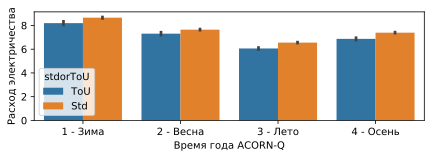

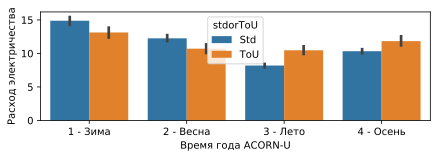

In [0]:
rcParams['figure.figsize'] = 7, 2
for i in list_acorn:
  tmp=res[res['Acorn']==i]
  graf=sns.barplot(x=tmp.season, y=tmp.energy_sum,hue=tmp.stdorToU)
  graf.set(xlabel='Время года '+str(i),ylabel='Расход электричества')
  plt.show()

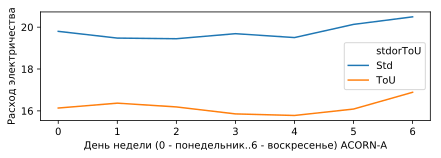

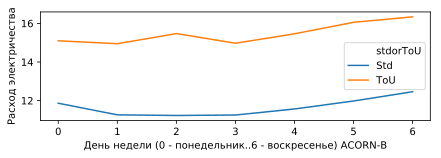

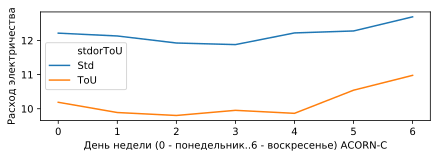

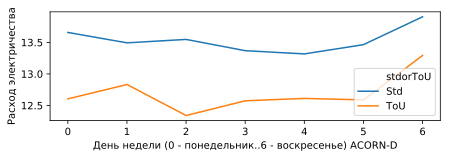

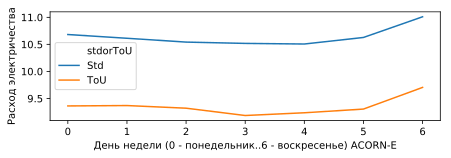

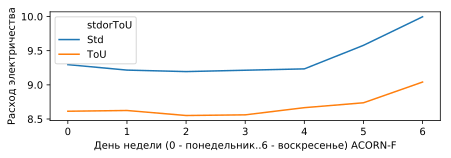

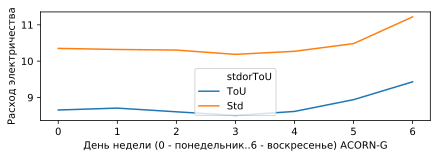

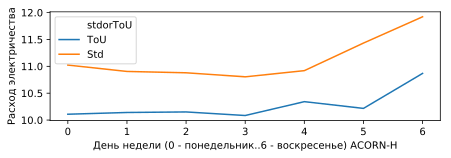

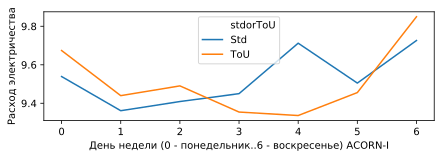

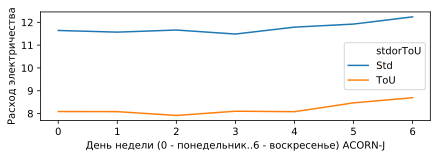

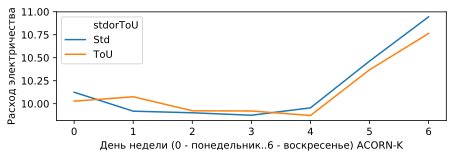

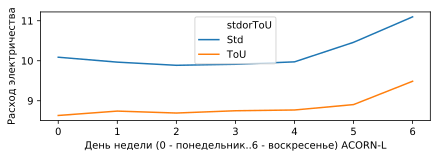

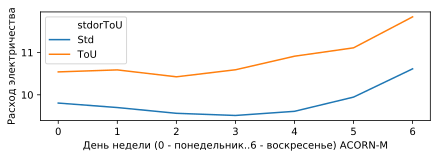

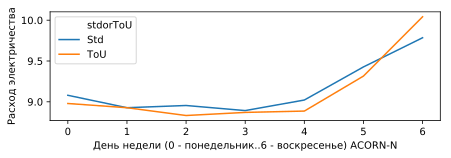

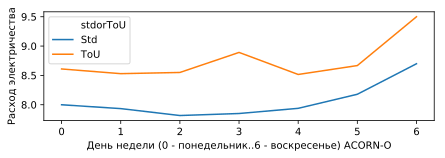

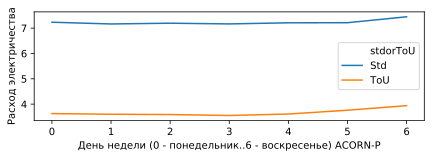

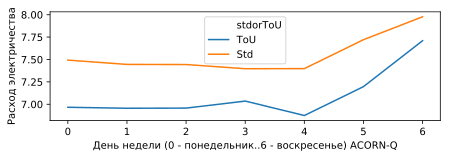

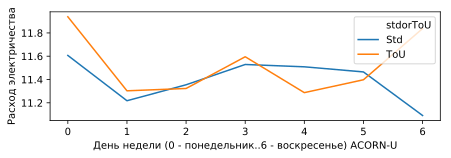

In [0]:
rcParams['figure.figsize'] = 7, 2
for i in list_acorn:
  tmp=res[res['Acorn']==i]
  graf=sns.lineplot(x=tmp.dn, y=tmp.energy_sum,hue=tmp.stdorToU, ci=None)
  graf.set(xlabel='День недели (0 - понедельник..6 - воскресенье) '+str(i),ylabel='Расход электричества')
  plt.show()

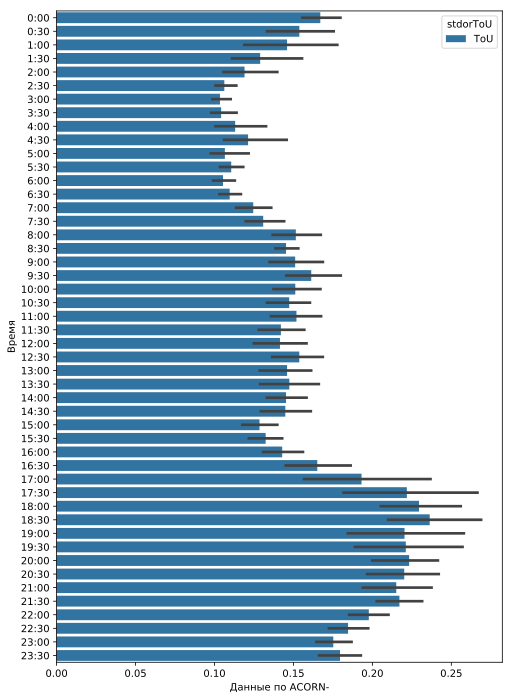

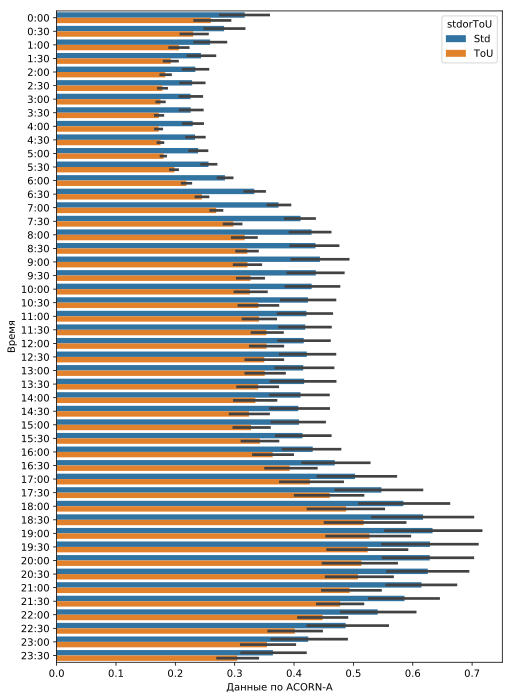

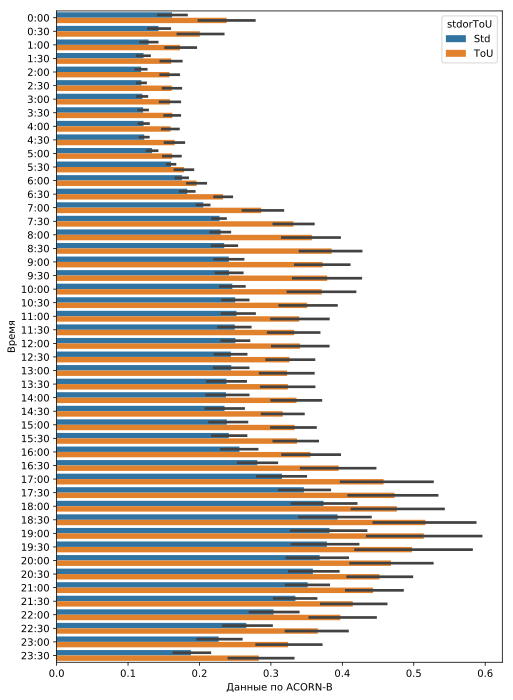

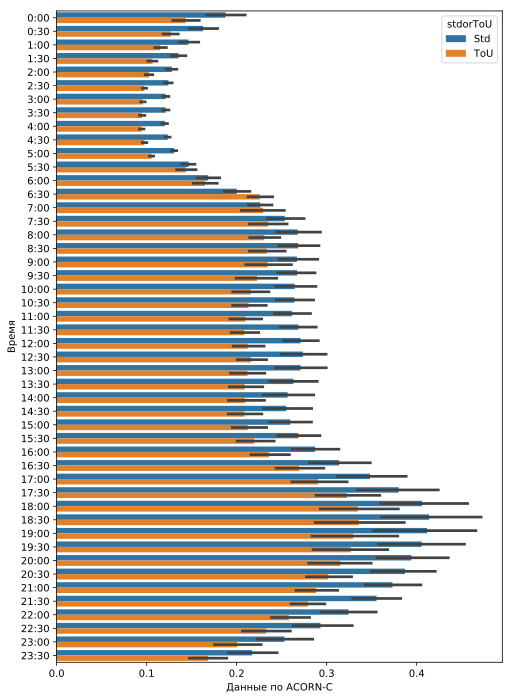

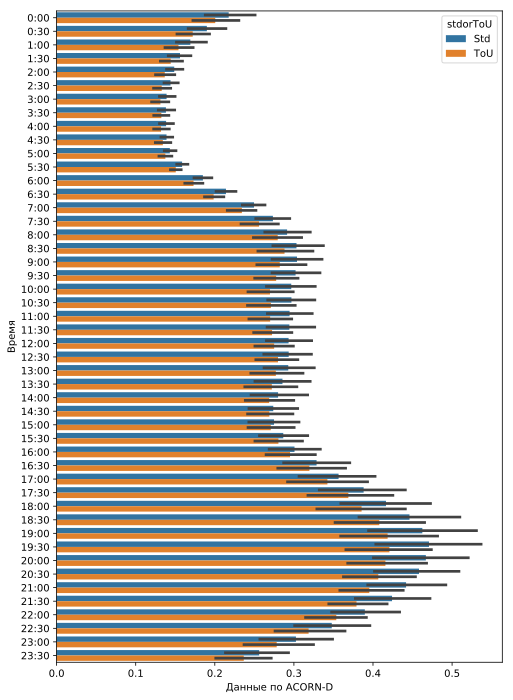

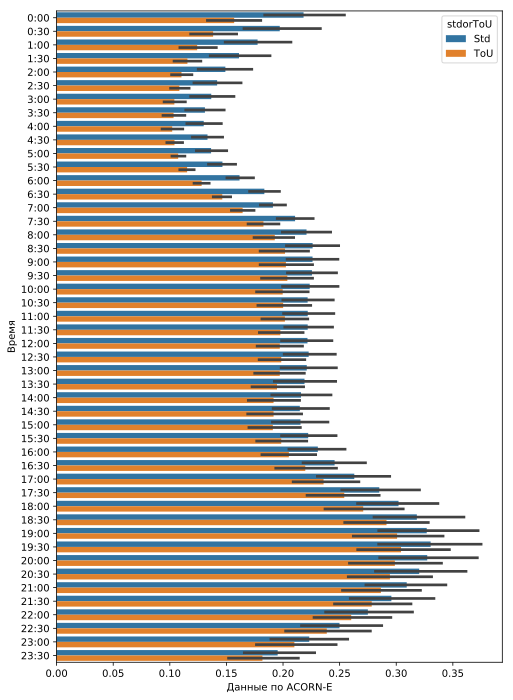

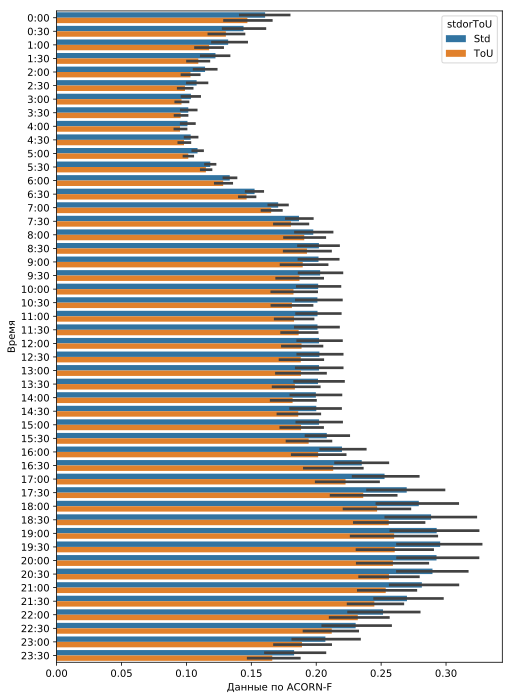

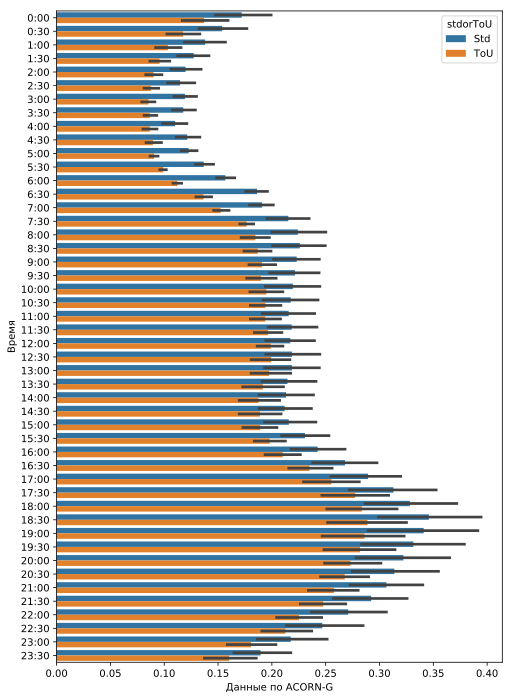

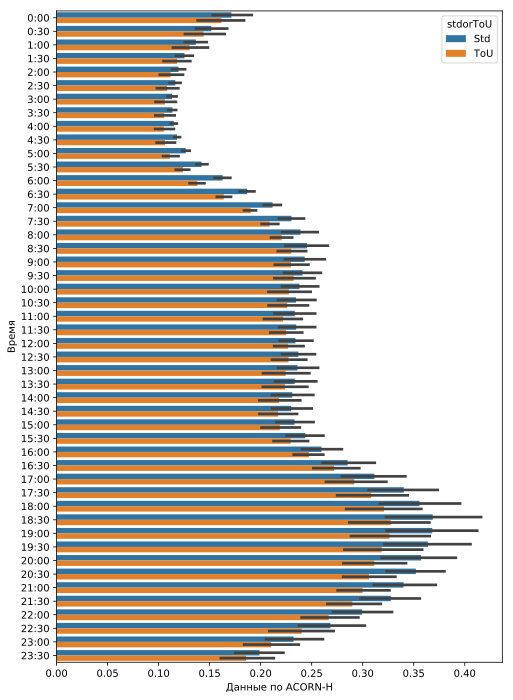

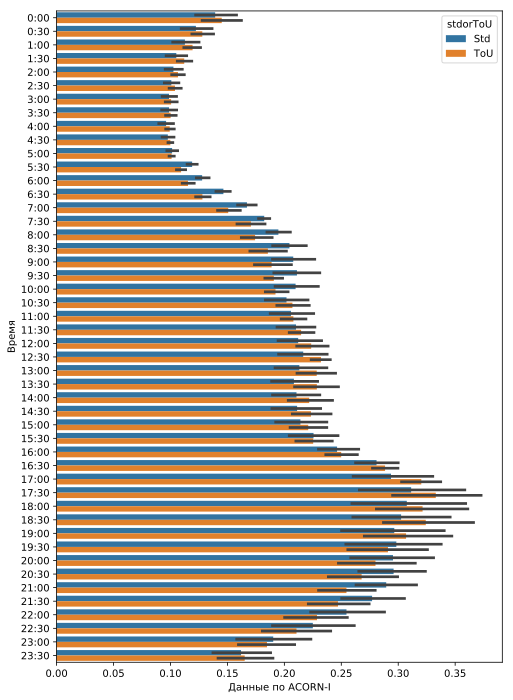

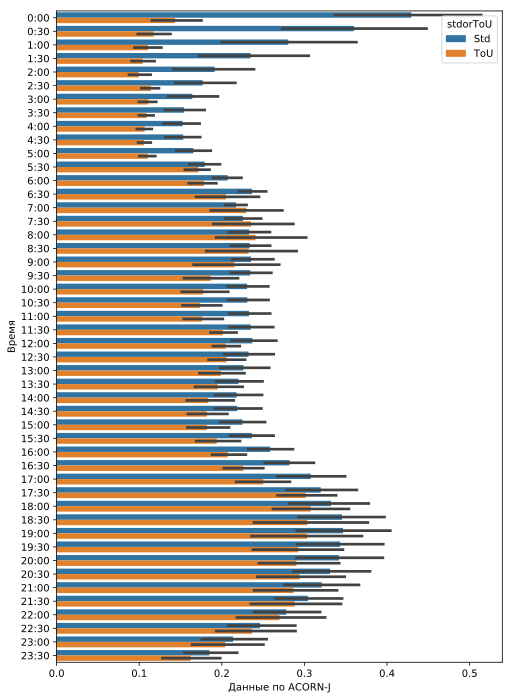

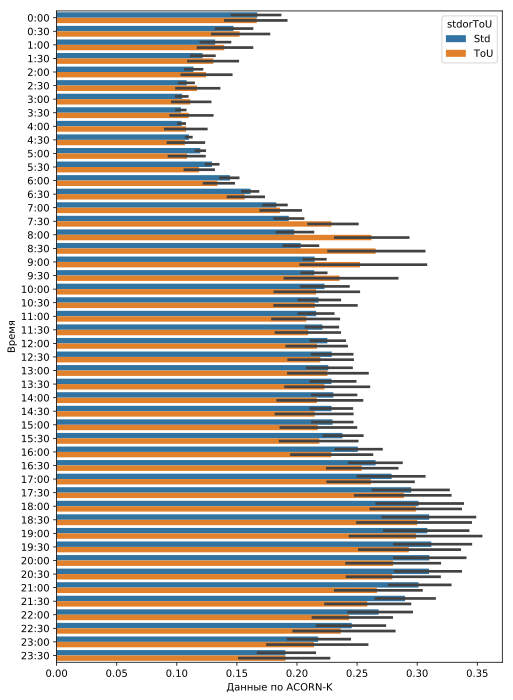

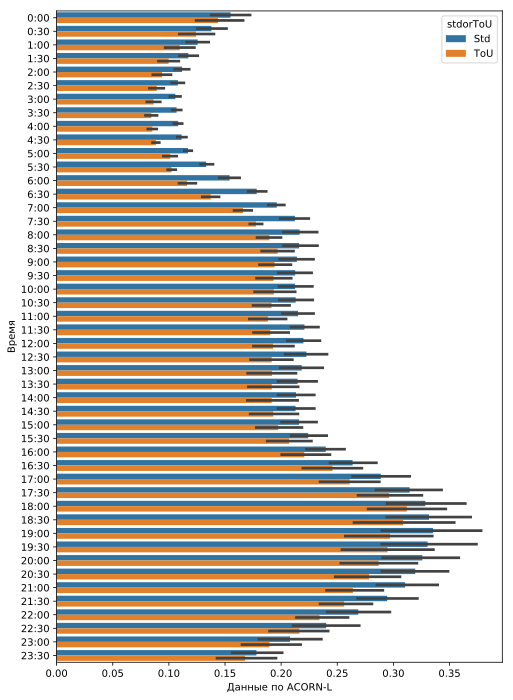

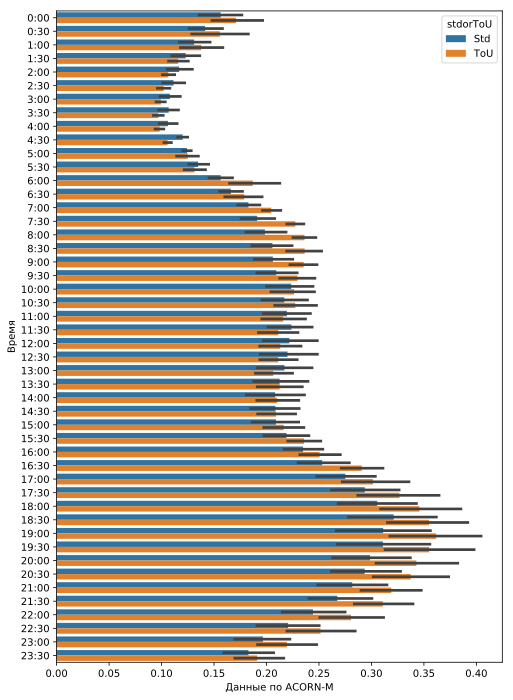

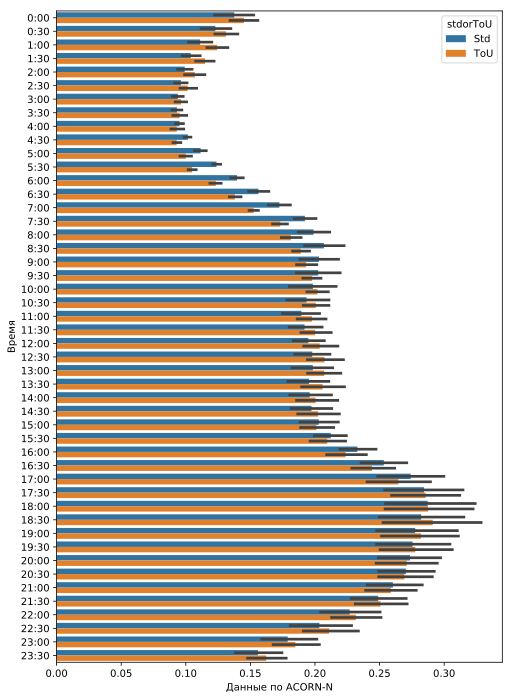

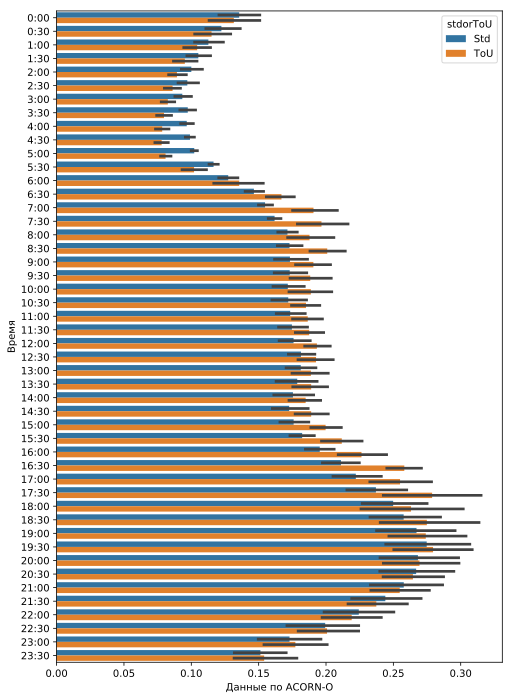

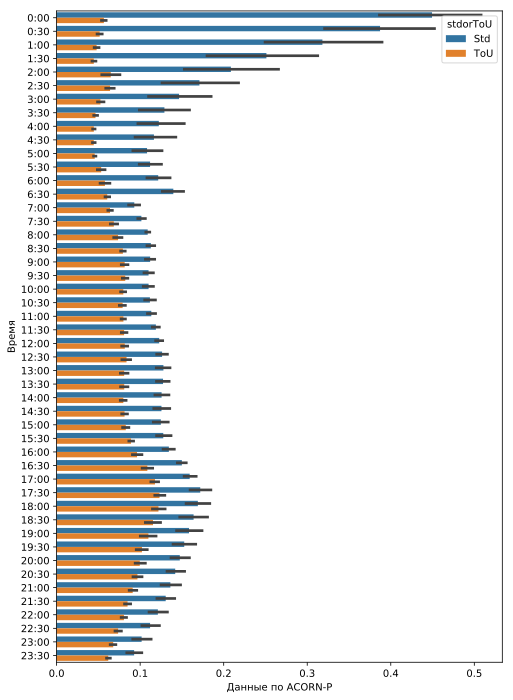

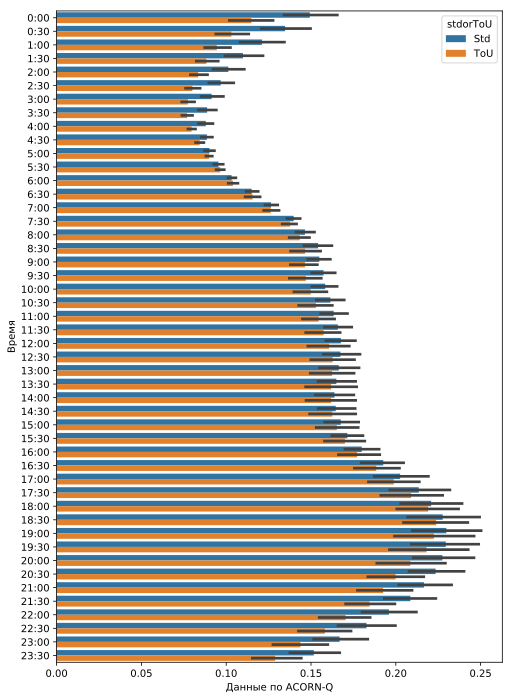

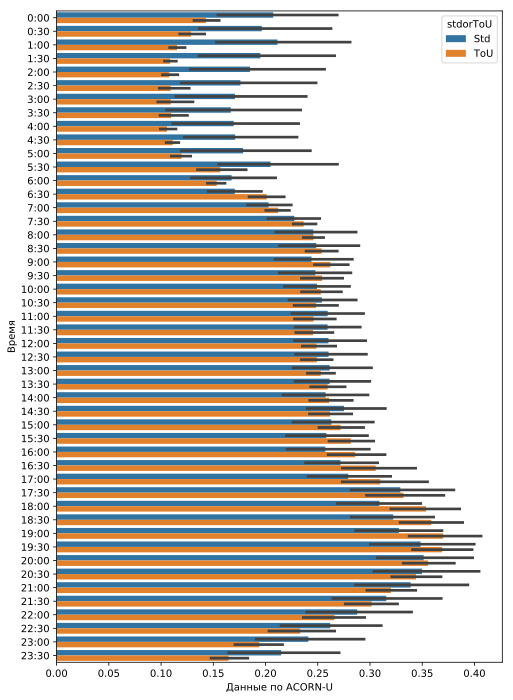

In [0]:
rcParams['figure.figsize'] = 8, 12
for i in list_acorn:
  tmp=res22[res22['Acorn']==i]
  graf=sns.barplot(x=tmp.val, y=tmp.tt,hue=tmp.stdorToU)
  graf.set(xlabel='Данные по '+str(i),ylabel='Время')
  plt.show()
  


# Проведем анализ зависимости количества потребленного электричества от погодных факторов

In [0]:
wdd=wdd[(wdd['time']>=start_date)&(wdd['time']<=end_date)]

Посмотрим, какое время в столбце time

In [0]:
wdd['time'].dt.hour.unique()

array([23,  0])

Получается, что встречается время 0 часов и 23 часа. Для анализа это плохо, поэтому  преобразуем время в столбце time  с помощью dt.normalize

In [0]:
wdd['time']=wdd['time'].dt.normalize()
wdd['time'].dt.hour.unique()

array([0])

Теперь с данными все в порядке, можно приступать  к дальнейшему анализу

In [0]:
res3=res.merge(wdd, left_on='day', right_on='time', how='left')

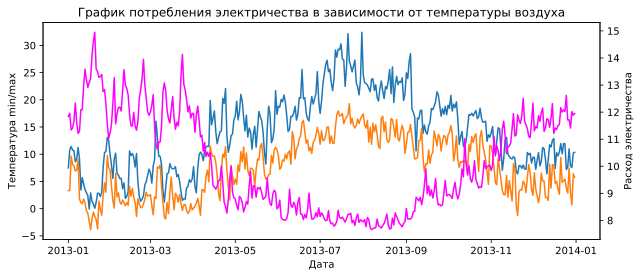

In [0]:
rcParams['figure.figsize'] = 10, 4
fig, ax = plt.subplots()
graf=sns.lineplot(x=res3.day, y=res3.temperatureMax, ci=None, ax=ax)  
graf=sns.lineplot(x=res3.day, y=res3.temperatureMin, ci=None, ax=ax)
graf.set(xlabel='Дата', ylabel='Температура min/max',title='График потребления электричества в зависимости от температуры воздуха')
ax2 = ax.twinx()
graf=sns.lineplot(x=res3.day, y=res3.energy_sum, ci=None, ax=ax2,color='magenta')
graf.set(xlabel='Дата', ylabel='Расход электричества')
plt.show()

По графику видно, что существует связь между потреблением электроэнергии и временем года. Сезонный эффект очень очевиден, т.к. используют электричество в качестве источника тепла. В теплое время (лето) электроэнергии тратится меньше, чем в холодное время (зима, осень, весна)

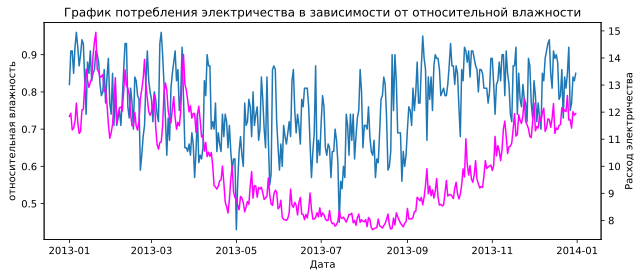

In [0]:
rcParams['figure.figsize'] = 10, 4
fig, ax = plt.subplots()
graf=sns.lineplot(x=res3.day, y=res3.humidity, ci=None, ax=ax)  
graf.set(xlabel='Дата', ylabel='относительная влажность',title='График потребления электричества в зависимости от относительной влажности')
ax2 = ax.twinx()
graf=sns.lineplot(x=res3.day, y=res3.energy_sum, ci=None, ax=ax2,color='magenta')
graf.set(xlabel='Дата', ylabel='Расход электричества')
plt.show()

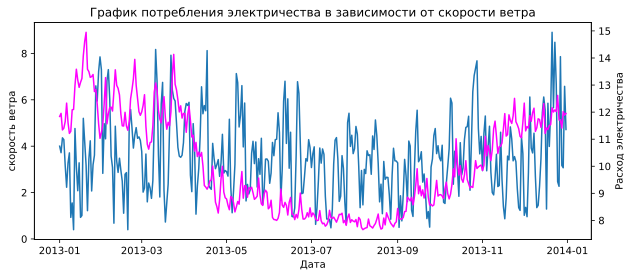

In [0]:
rcParams['figure.figsize'] = 10, 4
fig, ax = plt.subplots()
graf=sns.lineplot(x=res3.day, y=res3.windSpeed, ci=None, ax=ax)  
graf.set(xlabel='Дата', ylabel='скорость ветра',title='График потребления электричества в зависимости от скорости ветра')
ax2 = ax.twinx()
graf=sns.lineplot(x=res3.day, y=res3.energy_sum, ci=None, ax=ax2,color='magenta')
graf.set(xlabel='Дата', ylabel='Расход электричества')
plt.show()

В наших данных есть категориальные признаки, для анализа в таком виде они нам  не подходят. Поэтому преобразуем значения в уникальные числа с помощью модуля preprocessing библиотеки sklearn.

In [0]:
label = LabelEncoder()
dicts = {}
label.fit(res3.stdorToU.drop_duplicates()) 
dicts['stdorToU'] = list(label.classes_)
res3['stdorToU_tip'] = label.transform(res3['stdorToU']) 
#
label.fit(res3.Acorn.drop_duplicates()) 
dicts['Acorn'] = list(label.classes_)
res3['acorn_tip'] = label.transform(res3['Acorn']) 
#
label.fit(res3.season.drop_duplicates()) 
dicts['season'] = list(label.classes_)
res3['season_tip'] = label.transform(res3['season']) 

In [0]:
res3.drop(['season', 'diff','temperatureMaxTime','icon','dewPoint','temperatureMinTime','apparentTemperatureMinTime','apparentTemperatureHighTime','sunsetTime','sunriseTime','temperatureHighTime','uvIndexTime','summary','temperatureLowTime','apparentTemperatureMaxTime','apparentTemperatureLowTime','moonPhase','apparentTemperatureMin','apparentTemperatureLow','apparentTemperatureMax','uvIndex','apparentTemperatureHigh'], axis='columns', inplace=True)

Посмотрим на корреляцию:

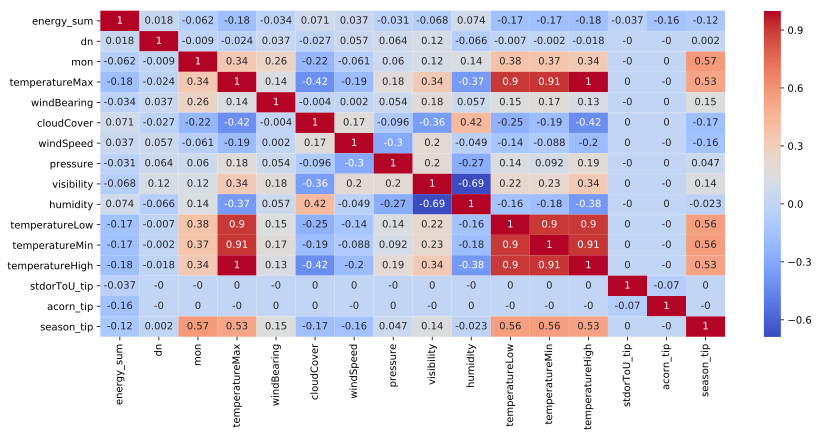

In [0]:
res3=res3.dropna()
correl=res3.corr().round(3)
rcParams['figure.figsize'] = 14, 6
sns.heatmap(correl, annot = True, cmap = 'coolwarm')
plt.show()

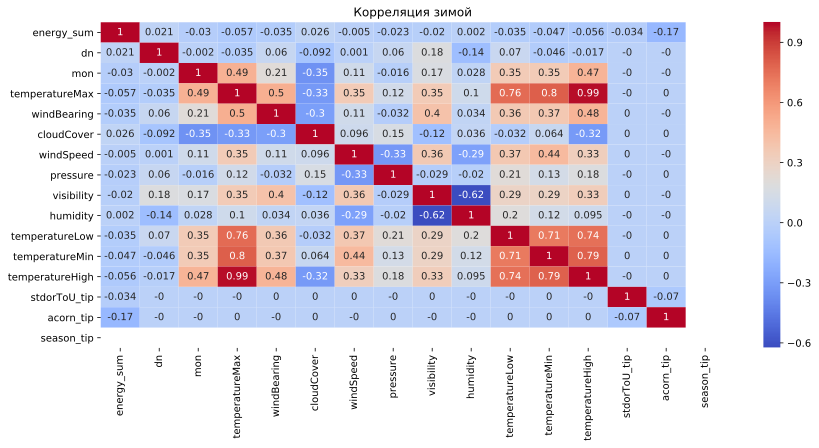

In [0]:
res4=res3[res3['season_tip']==0]
correl=res4.corr().round(3)
rcParams['figure.figsize'] = 14, 6
graf=sns.heatmap(correl, annot = True, cmap = 'coolwarm')
graf.set(title='Корреляция зимой')
plt.show()

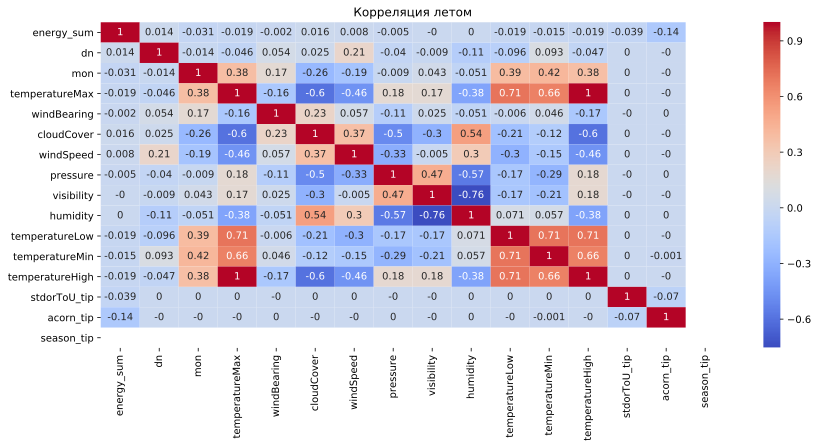

In [0]:
res4=res3[res3['season_tip']==2]
correl=res4.corr().round(3)
rcParams['figure.figsize'] = 14, 6
graf=sns.heatmap(correl, annot = True, cmap = 'coolwarm')
graf.set(title='Корреляция летом')
plt.show()